## Target guided encodings

So far, we can convert a **label into a number**, by using **one hot encoding**, **replacing by a digit** or **replacing by frequency** or **counts of observations**. These methods are **simple**, make (almost) no assumptions and **work generally well** in different scenarios.

The methods to allow to capture information while pre-processing the labels of categorical variables are: **ordering the labels** according to the target, **replacing labels by the target mean** (mean encoding / target encoding), **replacing the labels by the probability ratio** of the target being 1 or 0, and **Weight of evidence.** In all of them, the encoding is **guided by the target**, and they create a **monotonic relationship** between the variable and the target.

In a monotonic relationship, as the **value of one variable increases**, **the value of the other variable also increases** or **decreases**!

**Target guided encodings** captures **information within the category**, therefore creates **more predictive features and a monotonic relationship** between the variable and the target, therefore suitable for linear models, and do not expand the feature space!  but it is **prone to cause over-fitting** and **difficult to cross-validate with current libraries!**


**Note:** The methods discussed in this and the coming 3 lectures can be also used on numerical variables, after discretisation.

## Mean Encoding or Target Encoding

Mean encoding implies replacing the category by the average target value for that category. For example, if we have the variable city, with categories London, Manchester and Bristol, and we want to predict the default rate, if the default rate for London is 30% we replace London by 0.3, if the default rate for Manchester is 20% we replace Manchester by 0.2 and so on.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from feature_engine.encoding import MeanEncoder

In [2]:
data = pd.read_csv(
    'titanic.csv', usecols=['cabin', 'sex', 'embarked', 'survived'])
data.head()

,survived,sex,cabin,embarked
0,1,female,B5,S
1,1,male,C22,S
2,0,female,C22,S
3,0,male,C22,S
4,0,female,C22,S


**Fill na in embarked!**

In [3]:
data['embarked'].fillna('Missing', inplace=True)

**Extract the first letter of the cabin to create a simpler variable!**

In [4]:
data['cabin'] = data['cabin'].astype(str).str[0]

**Check how many labels each variable has!**

In [5]:
for col in data.columns:
    print(col, ': ', len(data[col].unique()), ' labels')

survived :  2  labels
sex :  2  labels
cabin :  9  labels
embarked :  4  labels


**Explore the unique categories!**

In [6]:
data['cabin'].unique()

array(['B', 'C', 'E', 'D', 'A', 'n', 'T', 'F', 'G'], dtype=object)

In [7]:
data['sex'].unique()

array(['female', 'male'], dtype=object)

In [8]:
data['embarked'].unique()

array(['S', 'C', 'Missing', 'Q'], dtype=object)

### Encoding important

We calculate **the target mean per category** using the train set, and then use those mappings in the test set.

In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    data[['cabin', 'sex', 'embarked', 'survived']],  # this time we keep the target!!
    data['survived'],  # target
    test_size=0.3,  # percentage of obs in test set
    random_state=0)  # seed to ensure reproducibility
X_train.shape, X_test.shape

((916, 4), (393, 4))

### Explore original relationship between categorical variables and target

**Explore the relationship of the categories with the target!**

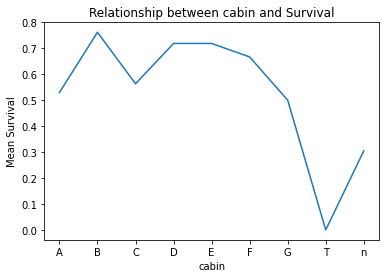

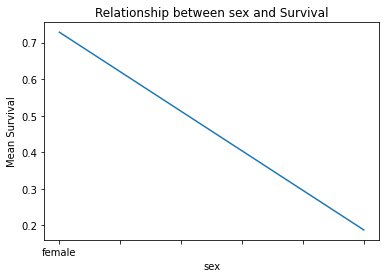

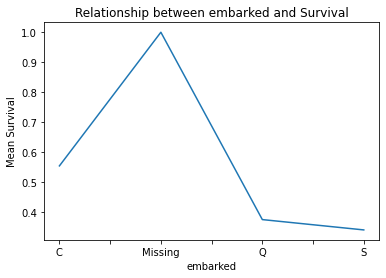

In [10]:
for var in ['cabin', 'sex', 'embarked']:
    fig = plt.figure()
    fig = X_train.groupby([var])['survived'].mean().plot()
    fig.set_title('Relationship between {} and Survival'.format(var))
    fig.set_ylabel('Mean Survival')
    plt.show()

You can see that the relationship between **the target and cabin and embarked** goes up and down, depending on the category.


## Mean encoding with pandas


It is **quick and returns pandas dataframe!** But it does **not preserve information** from train data to propagate to test data! We need to store the mappings separately if planning to use the model in production!

**Calculate the mean target value per category for cabin!**

In [11]:
X_train.groupby(['cabin'])['survived'].mean()

cabin
A    0.529412
B    0.761905
C    0.563380
D    0.718750
E    0.718750
F    0.666667
G    0.500000
T    0.000000
n    0.304843
Name: survived, dtype: float64

**Do the same but capturing the result in a dictionary!**

In [12]:
ordered_labels = X_train.groupby(['cabin'])['survived'].mean().to_dict()
ordered_labels

{'A': 0.5294117647058824,
 'B': 0.7619047619047619,
 'C': 0.5633802816901409,
 'D': 0.71875,
 'E': 0.71875,
 'F': 0.6666666666666666,
 'G': 0.5,
 'T': 0.0,
 'n': 0.30484330484330485}

**Replace the labels with the target means!**

In [13]:
X_train['cabin'] = X_train['cabin'].map(ordered_labels)
X_test['cabin'] = X_test['cabin'].map(ordered_labels)

**Explore the result!**

In [14]:
X_train['cabin'].head(10)

501     0.304843
588     0.304843
402     0.304843
1193    0.304843
686     0.304843
971     0.304843
117     0.718750
540     0.304843
294     0.563380
261     0.718750
Name: cabin, dtype: float64

**Turn the previous commands into 2 functions!**

In [15]:
def find_category_mappings(df, variable, target):
    return df.groupby([variable])[target].mean().to_dict()
def integer_encode(train, test, variable, ordinal_mapping):
    train[variable] = train[variable].map(ordinal_mapping)
    test[variable] = test[variable].map(ordinal_mapping)

**The loop over the remaining categorical variables!**

In [16]:
for variable in ['sex', 'embarked']:
    mappings = find_category_mappings(X_train, variable, 'survived')
    integer_encode(X_train, X_test, variable, mappings)

**See the result!**

In [17]:
X_train.head()

,cabin,sex,embarked,survived
501,0.304843,0.728358,0.338957,1
588,0.304843,0.728358,0.338957,1
402,0.304843,0.728358,0.553073,1
1193,0.304843,0.187608,0.373494,0
686,0.304843,0.728358,0.373494,1


**Inspect the newly created monotonic relationship between the variables and the target!**

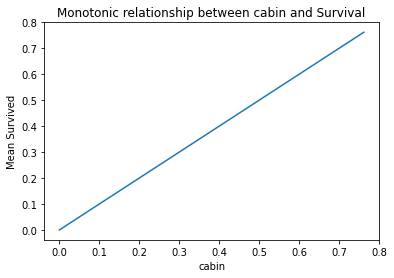

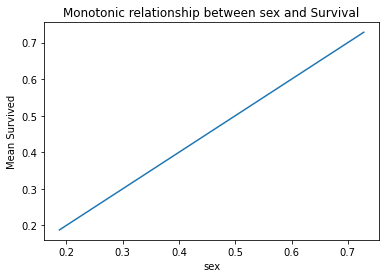

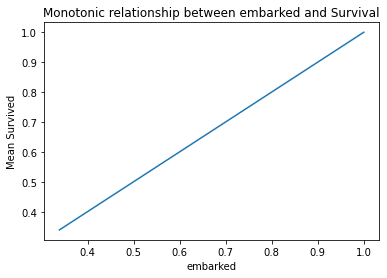

In [18]:
for var in ['cabin', 'sex', 'embarked']:
    fig = plt.figure()
    fig = X_train.groupby([var])['survived'].mean().plot()
    fig.set_title('Monotonic relationship between {} and Survival'.format(var))
    fig.set_ylabel('Mean Survived')
    plt.show()

Mean Encoding creates **linear relationships between the mean target and the categories.**

### Note

Replacing categorical labels with this code and method will **generate missing values for categories present in the test set** that were not seen in the training set. Therefore it is **extremely important to handle rare labels before-hand**. We will see how to do this, in a later notebook.

## Mean Encoding with Feature-Engine

If using **Feature-Engine**, instead of pandas, we do **not need to keep the target variable in the training dataset.**

In [19]:
X_train, X_test, y_train, y_test = train_test_split(
    data[['cabin', 'sex', 'embarked']],  # predictors
    data['survived'],  # target
    test_size=0.3,  # percentage of obs in test set
    random_state=0)  # seed to ensure reproducibility
X_train.shape, X_test.shape

((916, 3), (393, 3))

In [20]:
mean_enc = MeanEncoder(
    variables=['cabin', 'sex', 'embarked'])

**When fitting the transformer, we need to pass the target as well, just like with any Scikit-learn predictor class!**

In [21]:
mean_enc.fit(X_train, y_train)

MeanEncoder(variables=['cabin', 'sex', 'embarked'])

**In the encoder dict we see the target mean assigned to each category for each of the selected variables!**

In [22]:
mean_enc.encoder_dict_

{'cabin': {'A': 0.5294117647058824,
  'B': 0.7619047619047619,
  'C': 0.5633802816901409,
  'D': 0.71875,
  'E': 0.71875,
  'F': 0.6666666666666666,
  'G': 0.5,
  'T': 0.0,
  'n': 0.30484330484330485},
 'sex': {'female': 0.7283582089552239, 'male': 0.18760757314974183},
 'embarked': {'C': 0.553072625698324,
  'Missing': 1.0,
  'Q': 0.37349397590361444,
  'S': 0.3389570552147239}}

**The list of variables that the encoder will transform!**

In [23]:
mean_enc.variables_

['cabin', 'sex', 'embarked']

**Explore the result!**

In [24]:
X_train = mean_enc.transform(X_train)
X_test = mean_enc.transform(X_test)
X_train.head()

,cabin,sex,embarked
501,0.304843,0.728358,0.338957
588,0.304843,0.728358,0.338957
402,0.304843,0.728358,0.553073
1193,0.304843,0.187608,0.373494
686,0.304843,0.728358,0.373494


**Note**

If the argument variables is left to None, **then the encoder will automatically identify all categorical variables.** It is very sweet! The encoder will **not encode numerical variables**. So if some of your numerical variables are in fact categories, you will need to **re-cast them as object before using the encoder.** Finally, if there is a label in the test set that was not present in the train set, the encoder will through and error, to alert you of this behaviour.